# Overview

## Objective

## Data Description

## Import Libraries

In [275]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import Precision, Recall, AUC 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Rescaling, Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

In [276]:
# set the base directory for the data
base_dir = os.path.expanduser("~/projects/flatiron_p4/capstone/data/chest_xray")

# set the training, validation, and test directories
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

## Seeding
To ensure consistent results across all experiments, we will set a seed for the random number generator.

In [277]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

## Data Preparation

- Use ImageDataGenerator to read images from directories, convert them into floating-point tensors, and apply generalization.
- Normalize pixel values to be in the [0, 1] range.
- Reduce overfitting by using data augmentation (Generalization)
    - Prevents overfitting (since CNNs can memorize training images).
    - Simulates real-world variations like small rotations or shifts.
    - Helps the model generalize better to unseen images.

In [278]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

## Load Data
- Load the dataset using the flow_from_directory method.
- Our dataset is already divided into training and validation sets.
- The dataset contains 2 classes: `NORMAL` and `PNEUMONIA`.
    - /train directory is used for training the model.
    - /val directory is used for validating the model.
    - /test directory is used for testing the model.

### **IMG_SIZE** and **BAT_SIZE**
- X-ray images come in different resolutions.
- CNNs require a fixed input size.
- Downsampling to 150x150 balances computational cost and image detail.

In [279]:
# Define image size and batch size
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

### Load Data

In [280]:
train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    seed=SEED
)

val_generator = val_datagen.flow_from_directory(
    'data/val',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    seed=SEED
)

test_generator = test_datagen.flow_from_directory(
    'data/test',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    # important for evaluation
    shuffle=False  
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Sanity Check
- Ensure that the data is loaded correctly
- Check class names
- Check class distribution
- Visualize a few of the images in the dataset

In [281]:
# Check class names (should be ["NORMAL", "PNEUMONIA"])
class_names = list(train_generator.class_indices.keys())
print("Class names:", class_names)

Class names: ['NORMAL', 'PNEUMONIA']


In [282]:
# print the distribution of the data
print("Training Data")
print("Normal: ", len(os.listdir(os.path.join(train_dir, 'NORMAL'))))
print("Pneumonia: ", len(os.listdir(os.path.join(train_dir, 'PNEUMONIA'))))

Training Data
Normal:  1342
Pneumonia:  3876


Note that the dataset is imbalanced, with more pneumonia cases than normal cases.

## Model Architecture

We will use a Convolutional Neural Network (CNN) to classify the images. A Convolutional Neural Network (CNN) is ideal for image classification because it extracts features (like edges, textures, and shapes) using convolutional layers. 

### Model Definition

We will leverage a moderate CNN with the following layers:

- `Conv2D` -- Convolutional Layers 
    - Detects patterns like edges, textures, and shapes.
    - Uses small filters (kernels) (e.g., 3x3) to scan the image.
    - Activation function: ReLU (Rectified Linear Unit) (removes negative values to introduce non-linearity).

- `MaxPooling2D` -- Pooling Layers
    - Reduces spatial size while keeping important features.
    - Helps prevent overfitting and improves computational efficiency.
    - Common choice: MaxPooling (2x2).

- `Dropout` Layers
    - Randomly turns off neurons during training.
    - Helps prevent overfitting by forcing the model to generalize.

- `Dense` Fully Connected Layers
    - Takes extracted features and makes predictions.
    - Last layer uses Softmax (for multi-class classification) or Sigmoid (for binary classification).

- `Flatten` Layer
    - Converts the 2D matrix data to a vector.

- `relu` Activation Function
    - Introduces non-linearity.
    - Helps the model learn complex patterns.

- `sigmoid` activation function
    - Used in the output layer for binary classification.

In [283]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid') 
])

/Users/rob/micromamba/envs/pneumonia-dl/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Model Compilation
- Loss Function: Binary Crossentropy
The loss function tells the model how far its predictions are from the correct labels and guides weight updates. We use binary crossentropy for binary classification problems.

- Optimizer: Adam
The optimizer controls how the model updates its weights during training.
We use Adam (Adaptive Moment Estimation) because it automatically adjusts learning rates for each parameter, speeding up convergence.

- Metrics: Accuracy, Precision, Recall, AUC
    - Accuracy is simple and intuitive: it tells us what percentage of predictions are correct.
    - Precision tells us what percentage of positive predictions were correct.
    - Recall tells us what percentage of actual positives were correctly predicted.
    - AUC (Area Under the Curve) is the area under the ROC curve and tells us how well the model is distinguishing between classes.

In [284]:
# compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy", Precision(), Recall(), AUC()],
    )

model.summary()

Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_74 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_74 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_75 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_75 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_26 (Flatten)            │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 128)            │    10,616,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,636,481 (40.57 MB)

 Trainable params: 10,636,481 (40.57 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training
We add early stopping to prevent overfitting and reduce learning rate on plateau:

In [285]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)

/Users/rob/micromamba/envs/pneumonia-dl/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 40s 241ms/step - accuracy: 0.7465 - auc_18: 0.6118 - loss: 0.6372 - precision_17: 0.7471 - recall_17: 0.9967 - val_accuracy: 0.6250 - val_auc_18: 0.8203 - val_loss: 1.2383 - val_precision_17: 0.5714 - val_recall_17: 1.0000 - learning_rate: 0.0010
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 40s 244ms/step - accuracy: 0.8451 - auc_18: 0.9067 - loss: 0.3448 - precision_17: 0.8788 - recall_17: 0.9197 - val_accuracy: 0.6250 - val_auc_18: 0.8438 - val_loss: 1.2413 - val_precision_17: 0.5714 - val_recall_17: 1.0000 - learning_rate: 0.0010
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 38s 235ms/step - accuracy: 0.8617 - auc_18: 0.9199 - loss: 0.3261 - precision_17: 0.9023 - recall_17: 0.9131 - val_accuracy: 0.6250 - val_auc_18: 0.8828 - val_loss: 1.0553 - val_precision_17: 0.5714 - val_recall_17: 1.0000 - learning_rate: 0.0010
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 38s 231ms/step - accuracy: 0.8642 - auc_18: 0.9215 - loss: 0.3302 - precision_17: 0.9091 - recall_1

In [287]:
# save the model
model.save("models/baseline/baseline_model.keras")

## Model Evaluation
- We will evaluate the model on the test set using metrics like accuracy, precision, recall, and AUC.
- We will also visualize the confusion matrix to see how well the model is predicting each class.

In [ ]:
def test_suite(model, test_generator, history, dir):
    """Run a standardized set of evaluations on a trained model."""
    
    # predictions
    y_pred = (model.predict(test_generator) > 0.5).astype("int32").flatten()
    y_true = test_generator.classes
    class_names = list(test_generator.class_indices.keys())

    # model metrics
    loss, accuracy, precision, recall, auc = model.evaluate(test_generator)


    print("--------------------------------------------------")
    print("Model Metrics")
    print("--------------------------------------------------")
    print(f"Loss: {loss:.2f}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"AUC: {auc:.2f}")
    print("--------------------------------------------------")
    
    # save model metrics
    with open(f"{dir}/model_metrics.txt", "w") as f:
        f.write(f"Loss: {loss:.2f}\n")
        f.write(f"Accuracy: {accuracy:.2f}\n")
        f.write(f"Precision: {precision:.2f}\n")
        f.write(f"Recall: {recall:.2f}\n")
        f.write(f"AUC: {auc:.2f}\n")

    # classification Report
    report = classification_report(y_true, y_pred, target_names=class_names)

    print("Classification Report")
    print("--------------------------------------------------")
    print(report)
    print("--------------------------------------------------")
    
    # save classification report
    with open(f"{dir}/classification_report.txt", "w") as f:
        f.write(report)

    # confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    
    # save before showing
    plt.savefig(f"{dir}/confusion_matrix.png")
    plt.show()

    # training vs Validation Loss
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title("Training vs Validation Loss")
    
    plt.savefig(f"{dir}/loss.png")
    plt.show()

    # training vs Validation Accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title("Training vs Validation Accuracy")

    plt.savefig(f"{dir}/accuracy.png")
    plt.show()

    # training vs Validation Precision (if available)
    if 'precision' in history.history:
        plt.figure()
        plt.plot(history.history.get('precision', []), label='Train Precision')
        plt.plot(history.history.get('val_precision', []), label='Validation Precision')
        plt.legend()
        plt.title("Training vs Validation Precision")

        plt.savefig(f"{dir}/precision.png")
        plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.8712 - auc_18: 0.6036 - loss: 0.5536 - precision_17: 0.5383 - recall_17: 0.5705
Model Metrics
--------------------------------------------------
Loss: 0.40
Accuracy: 0.86
Precision: 0.92
Recall: 0.85
AUC: 0.90
--------------------------------------------------
Classification Report
--------------------------------------------------
              precision    recall  f1-score   support

      NORMAL       0.78      0.87      0.82       234
   PNEUMONIA       0.92      0.85      0.88       390

    accuracy                           0.86       624
   macro avg       0.85      0.86      0.85       624
weighted avg       0.87      0.86      0.86       624

--------------------------------------------------


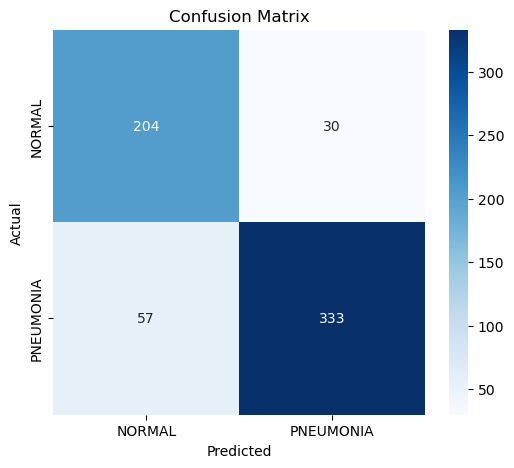

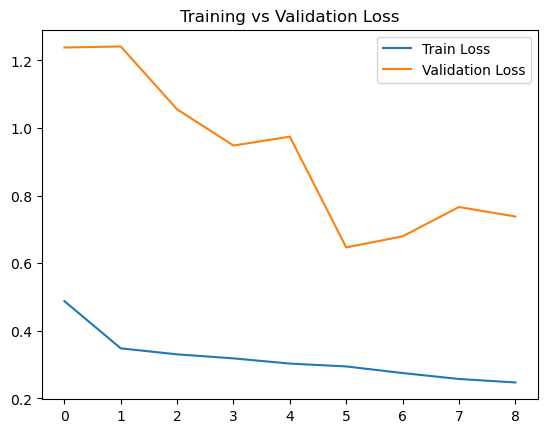

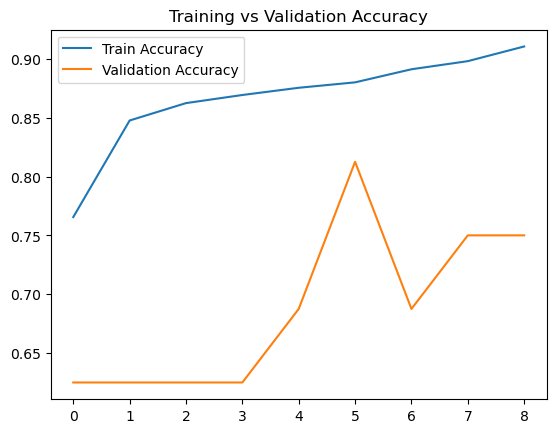

In [292]:
# run the test suite
test_suite(model, test_generator, history, "models/baseline")

## Evaluation Results

1. Overall
    - The model achieves an accuracy of 86% with a higher precision for `Pneumonia` (0.92) than `Normal` (0.78).
    - Recall for `Pneumonia` (0.85) is lower than precision, indicating that the model misses some pneumonia cases.
2. Signs of Overfitting 
    - Training accuracy is significantly higher than validation accuracy.
    - Training loss is lower than validation loss.
3. Class Imbalance
    - There are more `Pneumonia` (390) cases than `Normal` (234) cases.
    - The model performs better on the majority class (`Pneumonia`) than the minority class (`Normal`) suggested by the higher recall and precision for `Pneumonia`.
4. Strong class discrimination (AUC: 0.90)    

## Tuning Hyperparameters
- Improve data augmentation to prevent overfitting.
- Balance the dataset to address class imbalance.
- Regularize the model and add dropout layers to prevent overfitting.

### Data Augmentation
- Apply random transformations to the training images to make the model more robust.
- This will prevent the model from memorizing exact images and force it to learn general patterns.

In [293]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  
    width_shift_range=0.2,  
    height_shift_range=0.2,  
    shear_range=0.2,  
    zoom_range=0.2,  
    horizontal_flip=True
)

### Applying Dropout
- Add dropout layers to prevent overfitting.
- Dropout randomly turns off neurons during training, forcing the model to learn more robust features.

In [296]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid') 
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy", Precision(), Recall(), AUC()],
)

model.summary()

/Users/rob/micromamba/envs/pneumonia-dl/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_80 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_80 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_81 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_81 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_29 (Flatten)            │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 128)            │    10,616,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,636,481 (40.57 MB)

 Trainable params: 10,636,481 (40.57 MB)

 Non-trainable params: 0 (0.00 B)

### Class Weighing
- Address class imbalance by assigning higher weights to the minority class.
- This will help the model focus more on the minority class during training.

In [297]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weight = {i: class_weights[i] for i in range(len(class_weights))}
print("Class weights:", class_weight)

# train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight
)

# save the model
model.save("models/tuned/tuned_model.keras")

Class weights: {0: 1.9448173005219984, 1: 0.6730322580645162}
Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 243ms/step - accuracy: 0.5802 - auc_21: 0.6696 - loss: 0.7899 - precision_20: 0.8348 - recall_20: 0.5342 - val_accuracy: 0.8125 - val_auc_21: 0.8438 - val_loss: 0.5640 - val_precision_20: 0.7778 - val_recall_20: 0.8750 - learning_rate: 0.0010
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 39s 236ms/step - accuracy: 0.8246 - auc_21: 0.8995 - loss: 0.4019 - precision_20: 0.9445 - recall_20: 0.8125 - val_accuracy: 0.8125 - val_auc_21: 0.8828 - val_loss: 0.6040 - val_precision_20: 0.7273 - val_recall_20: 1.0000 - learning_rate: 0.0010
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 39s 238ms/step - accuracy: 0.8434 - auc_21: 0.9215 - loss: 0.3621 - precision_20: 0.9532 - recall_20: 0.8304 - val_accuracy: 0.6875 - val_auc_21: 0.8828 - val_loss: 0.8350 - val_precision_20: 0.6154 - val_recall_20: 1.0000 - learning_rate: 0.0010
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 38s 235ms/step - accuracy: 0.8689 - a

## Tuned Model Evaluation
- Evaluate the tuned model on the test set.
- Compare the results with the previous model.

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.8915 - auc_21: 0.6276 - loss: 0.2976 - precision_20: 0.5564 - recall_20: 0.5663
Model Metrics
--------------------------------------------------
Loss: 0.32
Accuracy: 0.88
Precision: 0.93
Recall: 0.86
AUC: 0.94
--------------------------------------------------
Classification Report
--------------------------------------------------
              precision    recall  f1-score   support

      NORMAL       0.80      0.90      0.84       234
   PNEUMONIA       0.93      0.86      0.90       390

    accuracy                           0.88       624
   macro avg       0.86      0.88      0.87       624
weighted avg       0.88      0.88      0.88       624

--------------------------------------------------


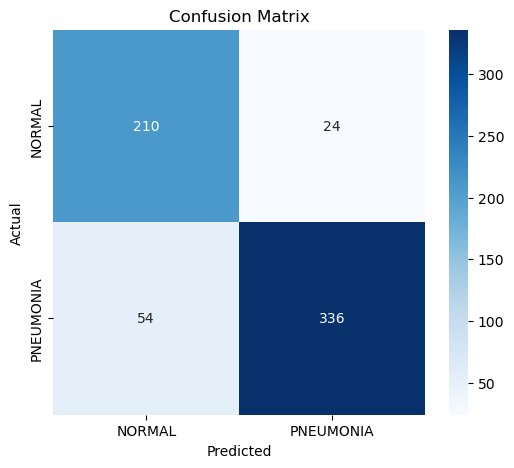

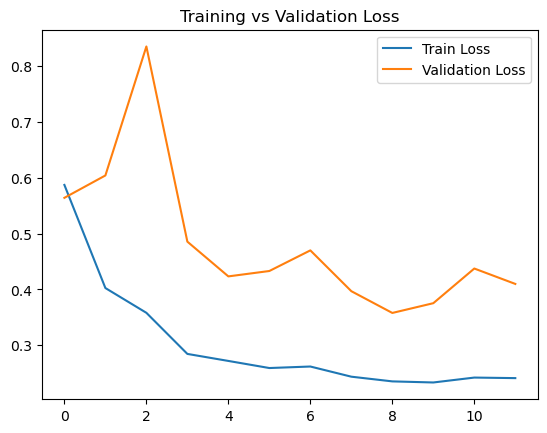

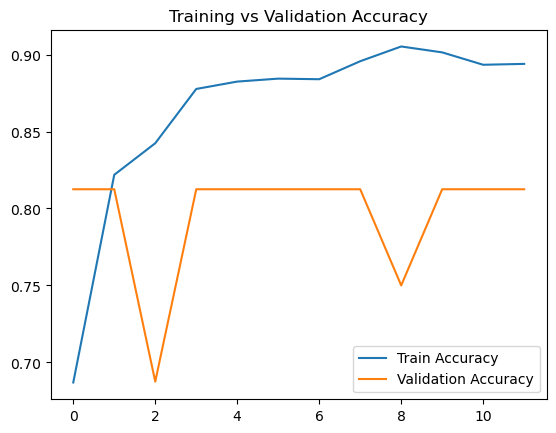

In [298]:
# run the test suite
test_suite(model, test_generator, history, "models/tuned")

## Tuned Model Evaluation 
1. Model Metrics
    - Loss: 0.40 -> 0.32 (better)
    - Accuracy: 0.86 -> 0.88 (better)
    - AUC: 0.90 -> 0.94 (better)
2. Class Metrics
    - All scores improved for both classes.
3. Confusion Matrix
    - All improved
4. Training vs. Validation Loss
    - Validation loss decreased more rapidly, suggesting better generalization.
    - Training loss remains consistently lower than validation loss, but the gap has reduced, indicating less overfitting.
5. Training vs. Validation Accuracy
    - Training accuracy consistently improves, but validation accuracy plateaus, suggesting better generalization.
    - The gap between training and validation accuracy has reduced, indicating less overfitting.


# Conclusion & Next Steps
- Use a pre-trained model like VGG16 or ResNet to leverage transfer learning.
- Fine-tune the pre-trained model on the X-ray dataset to improve performance.
- Experiment with different hyperparameters like learning rate, batch size, and optimizer to improve model performance.
- Continue to collect more data to improve the model's ability to generalize.
- Use higher-resolution images to capture more details and improve classification accuracy.